In [145]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
import datetime
from sklearn.base import BaseEstimator
import pdpipe as pdp
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import dill as pickle

In [134]:
dataset = pd.read_csv("/data/sundaram/walmart-recruiting-store-sales-forecasting/train.csv", names=['Store','Dept','Date','Weekly_Sales','isHoliday'],sep=',', header=0)
features = pd.read_csv("/data/sundaram/walmart-recruiting-store-sales-forecasting/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("/data/sundaram/walmart-recruiting-store-sales-forecasting/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset = dataset.merge(stores, how='left').merge(features, how='left')
dataset=dataset.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
dataset=pd.get_dummies(dataset,columns=['Type'])

In [135]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,isHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,211.096358,8.106,1,0,0
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,211.242170,8.106,1,0,0
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,211.289143,8.106,1,0,0
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,211.319643,8.106,1,0,0
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,211.350143,8.106,1,0,0


In [104]:
# dept = dataset['Dept'] == 1
# Store = dataset['Store'] == 1
# one_week_SD = dataset[dept & Store ]

In [112]:
one_week_SD.head()

,Store,Dept,isHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Type_A,Type_B,Type_C,month,Week_no
0,1,1,False,151315,42.31,2.572,211.096358,8.106,1,0,0,2,1
1,1,1,True,151315,38.51,2.548,211.242170,8.106,1,0,0,2,2
2,1,1,False,151315,39.93,2.514,211.289143,8.106,1,0,0,2,3
3,1,1,False,151315,46.63,2.561,211.319643,8.106,1,0,0,2,4
4,1,1,False,151315,46.50,2.625,211.350143,8.106,1,0,0,3,1


### Class for BaseEstimator & passing models

In [7]:

class ClfSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = LinearRegression(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

### preprocessing data

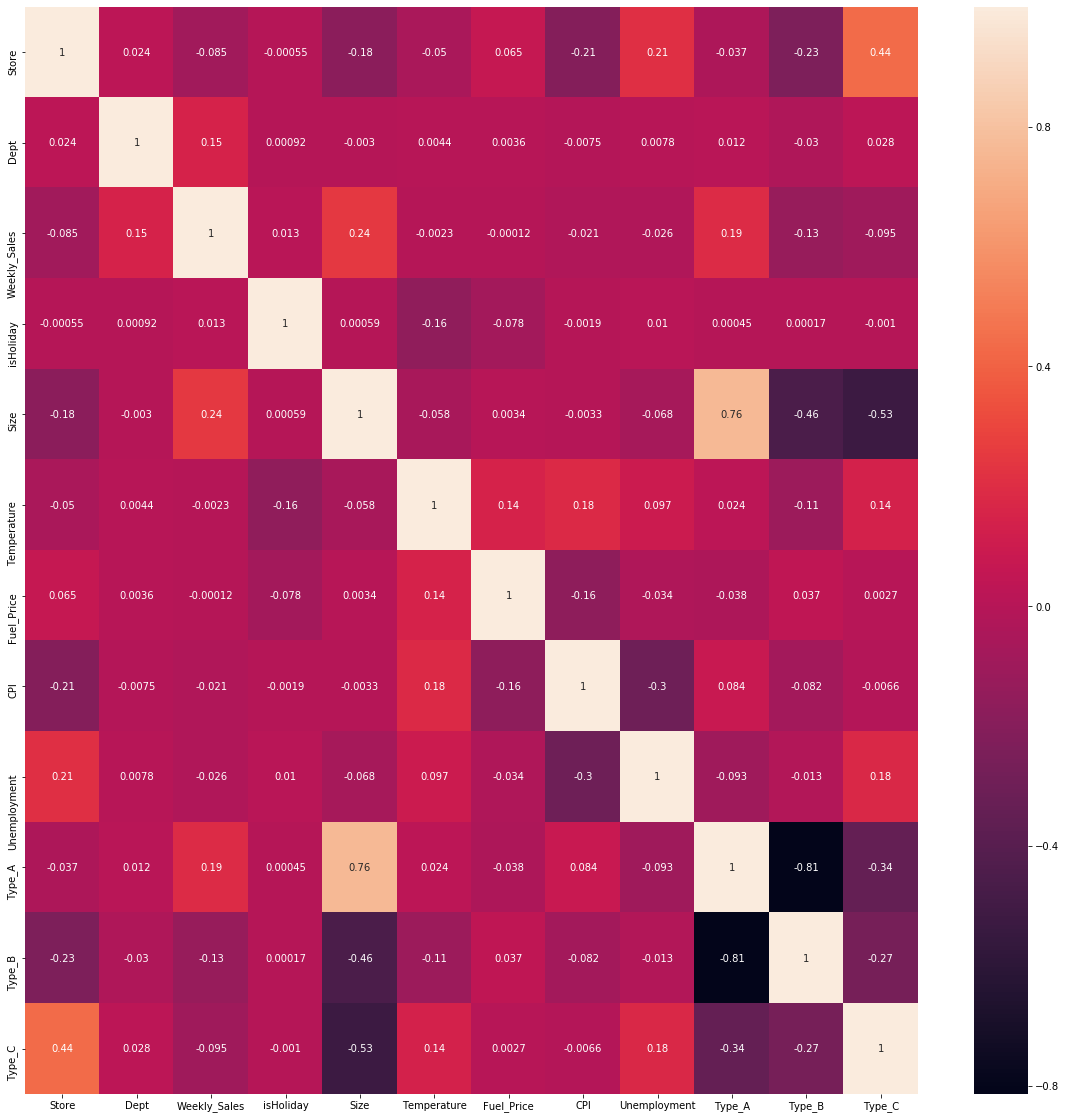

In [141]:
correlation=dataset.corr()
plt.figure(figsize=(20,20))

sns.heatmap(correlation, annot=True)


In [118]:
dataset ,to_be_predicted=preprocessing_walmart(dataset)
# one_week_SD,one_week_pred=one_store_dept(one_week_SD)

In [124]:
X_train.head()

,Store,Dept,isHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Type_A,Type_B,Type_C,month,Week_no
338670,35,82,False,103681,57.78,2.764,136.627732,8.763,0,1,0,10,2
165121,17,74,False,93188,51.04,3.778,129.062355,6.774,0,1,0,5,4
9708,1,95,False,151315,42.27,2.989,212.566881,7.742,1,0,0,2,1
275300,28,82,False,206302,53.13,3.950,130.550207,12.187,1,0,0,2,4
84869,9,54,False,125833,91.63,3.638,219.192985,6.404,0,1,0,8,2


In [121]:
X_train,X_test,Y_train,Y_test = train_test_split(dataset,to_be_predicted,random_state=42,test_size=0.3)
model=model_call(X_train,Y_train,X_test)
model.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standard',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reg',
                                        ClfSwitcher(estimator=LinearRegression(copy_X=True,
                                                                               fit_intercept=True,
                                                                               n_jobs=None,
                                                                               normalize=False)))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'reg__estimator': [LinearRegression(copy_X=Tr...
                          'reg__estimator__alpha': [0.1, 1, 1

In [122]:
model.best_score_

0.08936793209302504

In [117]:
def preprocessing_walmart(dataset):
    dataset['Day']=pd.to_datetime(dataset['Date'])
    panda_pipe=pdp.ApplyByCols('Day',lambda x: (x.day//7)+1,'Week_no',drop=False)
    panda_pipe+=pdp.ApplyByCols('Day',lambda x: x.month,'month',drop=False)
    panda_pipe+=pdp.ColDrop(['Date','Day'])
    dataset=panda_pipe(dataset)
    
#     dataset['Lag1']=dataset['Weekly_Sales'].shift(1)
#     dataset['Lag2']=dataset['Weekly_Sales'].shift(2)
#     dataset['Lag3']=dataset['Weekly_Sales'].shift(3)
#     dataset['Lag4']=dataset['Weekly_Sales'].shift(4)
#     dataset['Lag5']=dataset['Weekly_Sales'].shift(5)
#     dataset['Lag6']=dataset['Weekly_Sales'].shift(6)
    
    
    
    dataset=dataset.fillna(0)
    to_be_predicted=dataset['Weekly_Sales']
    dataset=dataset.drop(columns=['Weekly_Sales'])
    return (dataset,to_be_predicted)

In [61]:
def model_call(X_train,Y_train,X_test):
    #referenced class ClfSwitcher for optimal parameter
    pipe=Pipeline([('standard',StandardScaler()),('reg',ClfSwitcher())])
    '''
    class reference for selecting the best models
    '''

    params=[{'reg__estimator':[LinearRegression()]},
           {
            'reg__estimator':[Ridge()],
           'reg__estimator__alpha':[0.1,1,10]},
           {
            'reg__estimator':[Lasso()],
               'reg__estimator__alpha':[.001,.01,.1,1,10]},
           {
               'reg__estimator':[DecisionTreeRegressor()]
               
           }]

    #given evaluation states to pipe(ClfSwitcher(BaseEstimator=LinearRegression))

    #using gridsearchCV for best model selection
    gscv=GridSearchCV(pipe,params,cv=5)
    #gscv.fit(X_train,Y_train)
    return gscv

In [65]:
dataset.fillna(0)

,Store,Dept,IsHoliday,month,Week_no,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6
0,1,1,False,2,1,0.00,0.00,0.00,0.00,0.00,0.00
1,1,1,True,2,2,24924.50,0.00,0.00,0.00,0.00,0.00
2,1,1,False,2,3,46039.49,24924.50,0.00,0.00,0.00,0.00
3,1,1,False,2,4,41595.55,46039.49,24924.50,0.00,0.00,0.00
4,1,1,False,3,1,19403.54,41595.55,46039.49,24924.50,0.00,0.00
5,1,1,False,3,2,21827.90,19403.54,41595.55,46039.49,24924.50,0.00
6,1,1,False,3,3,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50
7,1,1,False,3,4,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49
8,1,1,False,4,1,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55
9,1,1,False,4,2,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54


In [62]:
# def preprocessing_walmart(dataset):
#     dataset['Day']=pd.to_datetime(dataset['Date'])
#     panda_pipe=pdp.ApplyByCols('Day',lambda x: (x.day//7)+1,'Week_no',drop=False)
#     panda_pipe+=pdp.ApplyByCols('Day',lambda x: x.month,'month',drop=False)
#     panda_pipe+=pdp.ColDrop(['Date','Day'])
#     dataset=panda_pipe(dataset)
    
   

#     #df=pd.DataFrame()
#     dataset['Lag1']=dataset['Weekly_Sales'].shift(1)
#     dataset['Lag2']=dataset['Weekly_Sales'].shift(2)
#     dataset['Lag3']=dataset['Weekly_Sales'].shift(3)
#     dataset['Lag4']=dataset['Weekly_Sales'].shift(4)
#     dataset['Lag5']=dataset['Weekly_Sales'].shift(5)
#     dataset['Lag6']=dataset['Weekly_Sales'].shift(6)
    
    
    
#     dataset=dataset.fillna(0)

#     to_be_predicted=dataset['Weekly_Sales']
#     dataset=dataset.drop(columns=['Weekly_Sales'])
#     return (dataset,to_be_predicted)

In [68]:
dataset

,Store,Dept,IsHoliday,month,Week_no,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6
0,1,1,False,2,1,0.00,0.00,0.00,0.00,0.00,0.00
1,1,1,True,2,2,24924.50,0.00,0.00,0.00,0.00,0.00
2,1,1,False,2,3,46039.49,24924.50,0.00,0.00,0.00,0.00
3,1,1,False,2,4,41595.55,46039.49,24924.50,0.00,0.00,0.00
4,1,1,False,3,1,19403.54,41595.55,46039.49,24924.50,0.00,0.00
5,1,1,False,3,2,21827.90,19403.54,41595.55,46039.49,24924.50,0.00
6,1,1,False,3,3,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50
7,1,1,False,3,4,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49
8,1,1,False,4,1,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55
9,1,1,False,4,2,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54


#### splitting data train&test

In [66]:
X_train,X_test,Y_train,Y_test = train_test_split(dataset,to_be_predicted,random_state=42,test_size=0.3)
model=model_call(X_train,Y_train,X_test)
model.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standard',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reg',
                                        ClfSwitcher(estimator=LinearRegression(copy_X=True,
                                                                               fit_intercept=True,
                                                                               n_jobs=None,
                                                                               normalize=False)))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'reg__estimator': [LinearRegression(copy_X=Tr...
                          'reg__estimator__alpha': [0.1, 1, 1

In [67]:
model.best_score_

0.914354693291914

## Pipeline for Multiple Models

In [48]:
# def model_call(X_train,Y_train,X_test):
#     #referenced class ClfSwitcher for optimal parameter
#     pipe=Pipeline([('standard',StandardScaler()),('reg',ClfSwitcher())])
#     '''
#     class reference for selecting the best models
#     '''

#     params=[{'reg__estimator':[LinearRegression()]},
#            {
#             'reg__estimator':[Ridge()],
#            'reg__estimator__alpha':[0.1,1,10]},
#            {
#             'reg__estimator':[Lasso()],
#                'reg__estimator__alpha':[.001,.01,.1,1,10]
#            }]

#     #given evaluation states to pipe(ClfSwitcher(BaseEstimator=LinearRegression))

#     #using gridsearchCV for best model selection
#     gscv=GridSearchCV(pipe,params,cv=5)
#     #gscv.fit(X_train,Y_train)
#     return gscv

In [377]:
gscv.best_score_

0.8940698318234831

In [378]:
gscv.best_params_

{'reg__estimator': Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 'reg__estimator__alpha': 10}

In [380]:
Y_predicted=gscv.predict(X_test)

In [405]:
# #pipeline=pdp.ApplyByCols('Date',pd.to_datetime('Date'),'Day')
# dataset['Day']=pd.to_datetime(dataset['Date'])



In [143]:
dataset

,Store,Dept,Date,Weekly_Sales,isHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,211.096358,8.106,1,0,0
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,211.242170,8.106,1,0,0
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,211.289143,8.106,1,0,0
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,211.319643,8.106,1,0,0
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,211.350143,8.106,1,0,0
5,1,1,2010-03-12,21043.39,False,151315,57.79,2.667,211.380643,8.106,1,0,0
6,1,1,2010-03-19,22136.64,False,151315,54.58,2.720,211.215635,8.106,1,0,0
7,1,1,2010-03-26,26229.21,False,151315,51.45,2.732,211.018042,8.106,1,0,0
8,1,1,2010-04-02,57258.43,False,151315,62.27,2.719,210.820450,7.808,1,0,0
9,1,1,2010-04-09,42960.91,False,151315,65.86,2.770,210.622857,7.808,1,0,0


In [146]:
with open("/home/sundaram/new_model.pkl",'rb') as nll_file:
    model=pickle.load(nll_file)

In [ ]:
temp=